In [18]:
# import necessary libraries
# ensure the libraries are installed from requirements.txt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path

In [19]:
# define global constants

# points towards the data with the magic wand held idle
IDLE_PATH = Path("data/raw_data/idle.csv")
# points towards the data with the magic wand being rotated
CIRCLE_PATH = Path("data/raw_data/circle.csv")
# the maximum value that the MPU sensor can output
MPU_MAX_OUT = 32768
# use 10% of data for testing
TEST_FRAC = 0.1
# use 10% of data for validation 
VAL_FRAC = 0.1
# the number of consecutively recorded data points that are assembled to an image
TIME_FRAME = 128
# the number of classes
NUM_CLASSES = 2
# data dimension associated with a single data point in time
# the MPU records x, y and z axis acceleration
SENSOR_DIM = 3
# output paths to which the processed output is written
TRAIN_Y_PATH = Path("data/train_y.csv")
VAL_Y_PATH = Path("data/val_y.csv")
TEST_Y_PATH = Path("data/test_y.csv")
TRAIN_X_PATH = Path("data/train_x.csv")
VAL_X_PATH = Path("data/val_x.csv")
TEST_X_PATH = Path("data/test_x.csv")


In [20]:
def load_data(gen_synth_data = False):
    """load data and convert to desired format."""
    
    if gen_synth_data:
        # two classes, with three columns
        # each column has an upper and a lower bound 
        # classes:              idle,                  circle
        lower_bounds_by_class = [[-1824, 5104, -5648], [-5724, -12736, -13380]]
        upper_bounds_by_class = [[9772, 19136, 4600], [10444, 32767, 12244]]
        class_li = []
        # select the data for a class
        for class_l, class_u  in zip(lower_bounds_by_class, upper_bounds_by_class):
            col_li = []
            # select a single column
            for l, u in zip(class_l, class_u):
                col = np.random.randint(l, u, 128000)[..., np.newaxis]
                col_li.append(col)
            class_li.append(np.hstack(col_li))
        return class_li # dim: list with two elements
        # each element in list is a 3 x 128000 numpy matrix

    # load the CSV files into pandas dataframes
    df_idle_data = pd.read_csv(IDLE_PATH)
    df_circle_data = pd.read_csv(CIRCLE_PATH)
    print(len(df_idle_data))

    # convert pandas dataframes to numpy arrays
    np_idle_data = df_idle_data.to_numpy()
    np_circle_data = df_circle_data.to_numpy()
    return np_idle_data, np_circle_data

def exploratory_plot(idle_data, circle_data):
    """visualize the recorded data for exploration."""
    # define an image with two subplots
    _, axis = plt.subplots(2, 1, figsize=(16,16))
    # visualize the idle data
    axis[0].plot(idle_data)
    axis[0].set_title("Idle data")
    # visualize the circle data
    axis[1].plot(circle_data)
    axis[1].set_title("Circle data")
    # make the figure
    plt.show()

128000


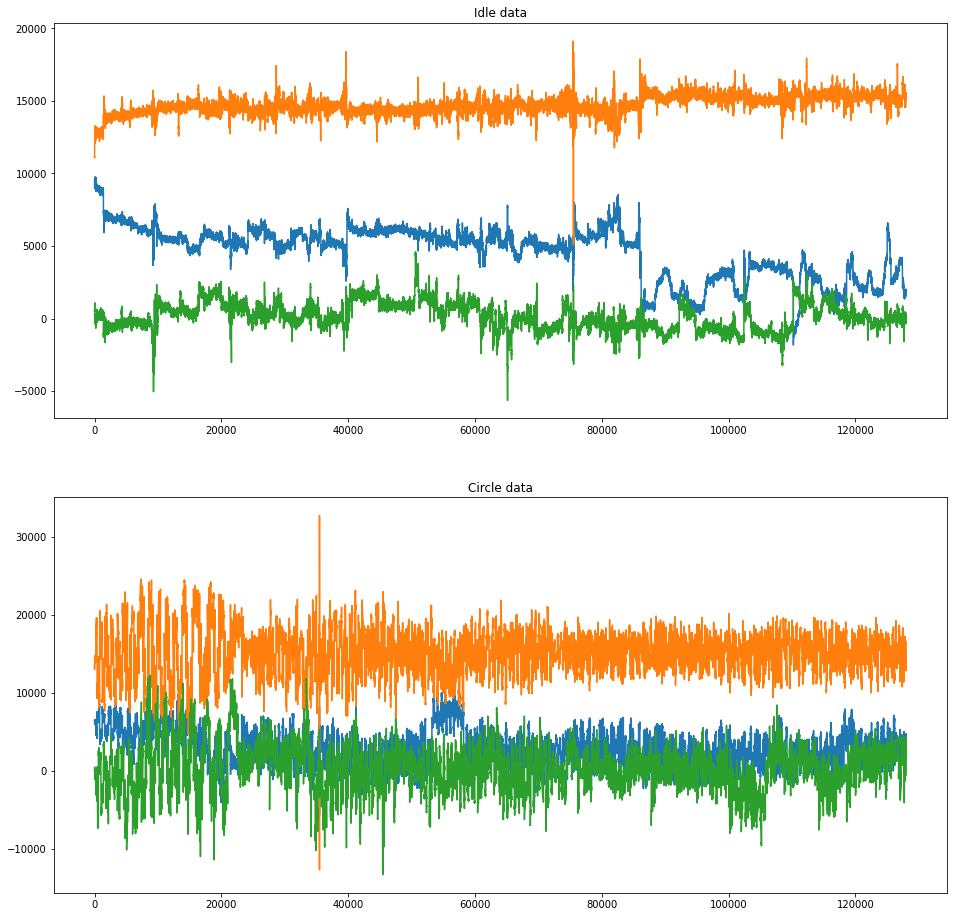

In [21]:
np_idle_data, np_circle_data = load_data()
exploratory_plot(np_idle_data, np_circle_data)

In [22]:
def norm(data):
    """normalize a single MPU data point to the interval 0 to 1."""
    return (data + MPU_MAX_OUT) / (MPU_MAX_OUT-1 + MPU_MAX_OUT)

def normalize_data(data):
    """normalize a series of MPU data points."""
    # store data shape information for back-conversion
    num_data_points = len(data)

    # convert data from shape (128000, 3)
    # to shape (128000 * 3, 1)
    # in order to easily apply normalization
    data = data.flatten()

    # apply normalization to each entry
    data = norm(data)

    # undo flattening
    return data.reshape(num_data_points, SENSOR_DIM)

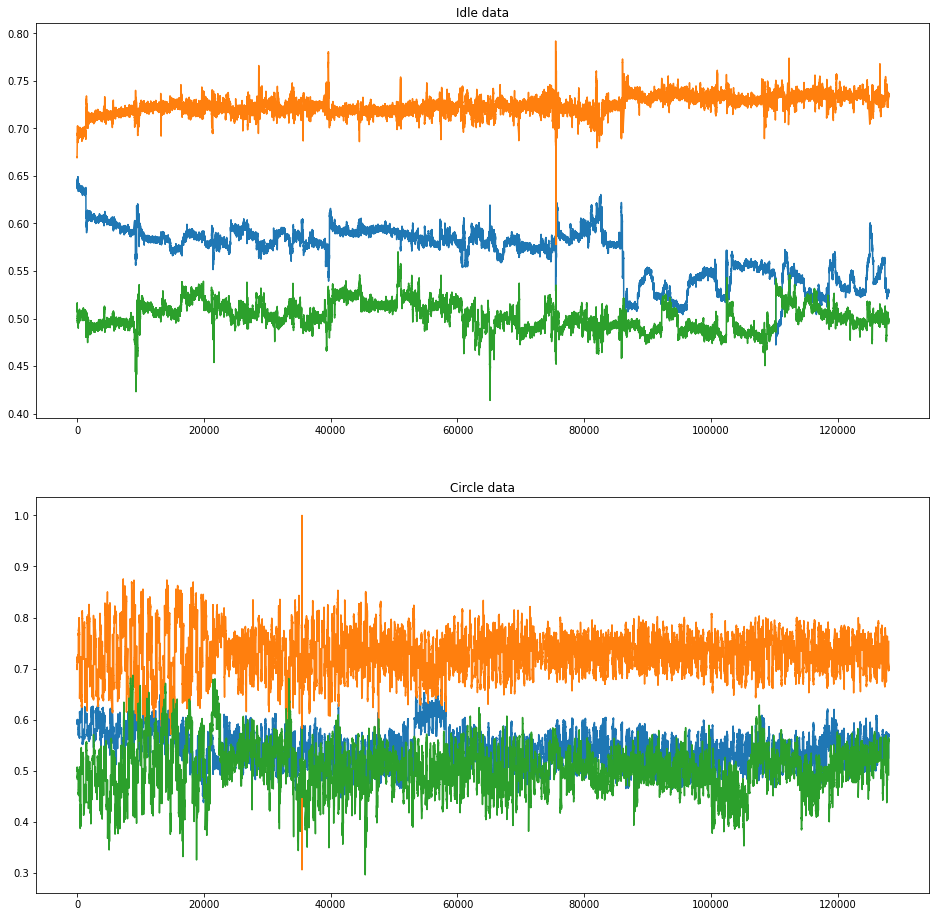

In [23]:
norm_idle = normalize_data(np_idle_data)
norm_circ = normalize_data(np_circle_data)
exploratory_plot(norm_idle, norm_circ)

In [24]:
def train_test_split(data):
    """split data into three distinct sets."""
    l = len(data)
    cutoff1 = int(l*VAL_FRAC)
    cutoff2 = int(l*VAL_FRAC+l*TEST_FRAC)
    val = data[:cutoff1,]
    test = data[cutoff1:cutoff2,]
    train = data[cutoff2:,]
    return train, val, test

def save_data(train_idle, train_circ, val_idle, val_circ, test_idle, test_circ):
    """combine classes and save data to CSV."""
    train_X = np.concatenate((train_idle, train_circ))
    val_X = np.concatenate((val_idle, val_circ))
    test_X = np.concatenate((test_idle, test_circ))
    # reducing to 5 decimal places because of the sensor resolution
    np.savetxt(TRAIN_X_PATH, train_X, delimiter=",", fmt="%.5f")
    np.savetxt(VAL_X_PATH, val_X, delimiter=",", fmt="%.5f")
    np.savetxt(TEST_X_PATH, test_X, delimiter=",", fmt="%.5f")


In [25]:
# perform train, val, test split
train_circ, val_circ, test_circ = train_test_split(norm_circ)
train_idle, val_idle, test_idle = train_test_split(norm_circ)
# save data
save_data(train_idle, train_circ, val_idle, val_circ, test_idle, test_circ)

In [26]:
def num_images(data):
    """calculate number of images after reshaping to images."""
    return data.shape[0]//TIME_FRAME

def make_labels(train, val, test):
    """make labels for each set for both classes."""
    # idle movements are labeled with 0
    train_y = np.zeros(num_images(train))
    val_y = np.zeros(num_images(val))
    test_y = np.zeros(num_images(test))
    # circle movements are labeled with 1
    train_y = np.concatenate((train_y, np.ones(num_images(train))))
    val_y = np.concatenate((val_y, np.ones(num_images(val))))
    test_y = np.concatenate((test_y, np.ones(num_images(test))))
    # save labels to file as CSV so that they can be loaded later on
    np.savetxt(TRAIN_Y_PATH, train_y, delimiter=",", fmt="%d")
    np.savetxt(VAL_Y_PATH, val_y, delimiter=",", fmt="%d")
    np.savetxt(TEST_Y_PATH, test_y, delimiter=",", fmt="%d")

In [27]:
make_labels(train_circ, val_circ, test_circ)